In [1]:
%matplotlib inline
from diffusion_maps import diff_map_solver
from dataloader import *
from plotter import *
import numpy as np

In [2]:
hyper_params = {
               #Higher dimension size
               'dim_H' : 9,
               #Density of the simulation (dimensionless)
               'density' : 0.003,
               #Num of particles in cluster
               'num_particles' : 3,
               #Number of configurations to be used (5001 is total)
               'num_data' : 500
               }
            
#initialize solver using the defined above  
diff_map_solver = diff_map_solver(hyper_params)
diff_map_solver.num_steps = diff_map_solver.num_data

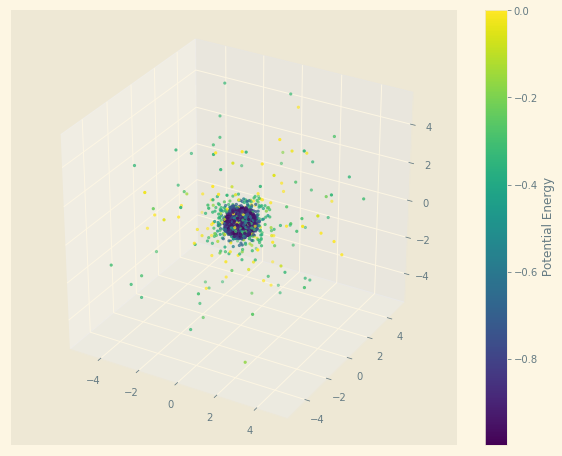

In [3]:
#load dataset
coordinates = load_features("../data/3P_CENTERED_COORDINATES.txt")
potentials = load_labels("../data/3P_T018_POTENTIALS.txt", 1)

coordinates = coordinates[:hyper_params['num_data']]
potentials = potentials[:hyper_params['num_data']]


x = []
y = []
z = []
c = []
for i in range(len(coordinates)):
    for j in range(0, len(coordinates[i]), 3):
        x.append(coordinates[i][j+0])
        y.append(coordinates[i][j+1])  
        z.append(coordinates[i][j+2])
        c.append(potentials[i])
plt.style.use('Solarize_Light2')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
a = ax.scatter(x, y, z, s=5, c=np.array(c).flatten())
fig.colorbar(a, label=' Potential Energy')
plt.show()

# STEP 1: Calculate R and G 

$$
   R =
  \left[ {\begin{array}{cc}
   0 & r_{12} & r_{13} \\
   r_{21} & 0 & r_{23} \\
   r_{31} & r_{32} &0 \\
  \end{array} } \right] \\ \\
$$

Where $r_{ij}$ is distance between particle i and j and G is basically turning R into a binary array (0 and 1) based on cutoff distance.


In [4]:
R, G = diff_map_solver.calculate_R_G(coordinates)

# STEP 2: Execute ISO rank algorithm to get best representing alignments(will add explanation soon.. )

In [5]:
R_, G_ = diff_map_solver.isorank(coordinates, R, G)

# STEP 3: Calc distance matrix

The distance matrix is the result of non-linear kernel making it non-linear version of PCA

$$d = \sum_{i} |R^*_i*G^*_i - R_i G_i| = 1$$



In [6]:
d = diff_map_solver.compute_d(R, G, R_, G_)

In [7]:
#compute A matrix (A_ij = e^(d_ij^2 / 2*sigma))
A = diff_map_solver.compute_A(d)

In [8]:
#compute D matrix
D = diff_map_solver.compute_D(A)

In [9]:
#compute M matrix = D' * A
M = diff_map_solver.compute_M(D, A)

/anaconda2/lib/python2.7/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


explained variance saved in exp_cuml_var.png!


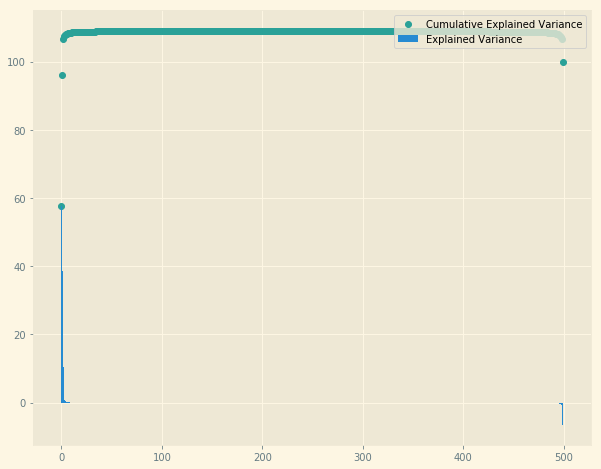

In [10]:
eig_vals, eig_vecs = diff_map_solver.generate_eigenspace(M)
#sort the eigen space in descending order
#calculate and plot the variance of each eigenvalue
diff_map_solver.plot_explained_variance(eig_vals);

We can see that the first three eigenvalues basically explain 100% of the variance! Proving dimensionality can be reduced to 2. We need to ignore the first eigenvector as it represents transition to itself. Now Lets see how the reduced space looks like

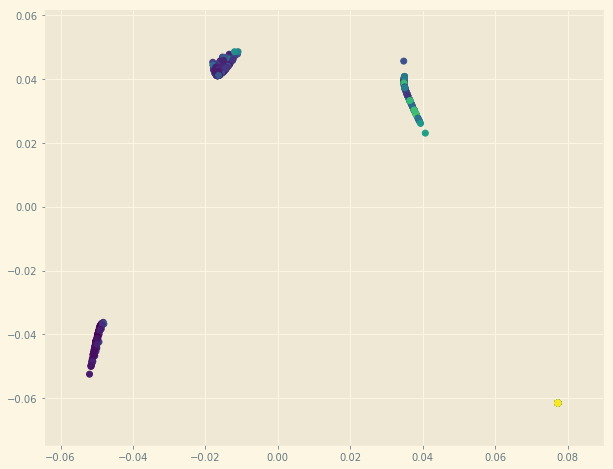

In [11]:
diff_map_solver.plot_new_space_2d(eig_vals, eig_vecs, np.reshape(potentials[:hyper_params['num_data']], hyper_params['num_data']))


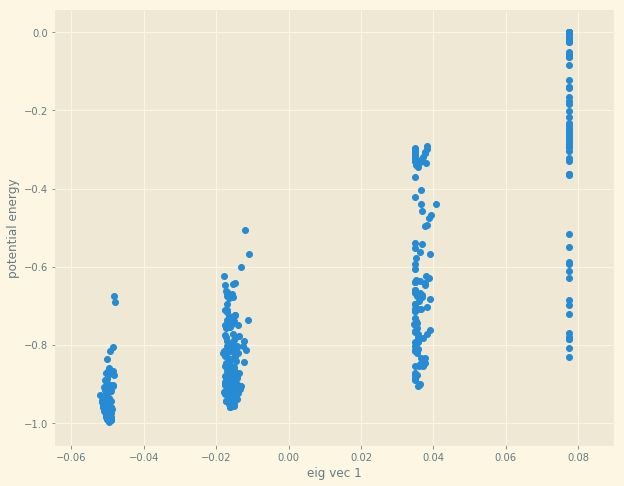

In [12]:
diff_map_solver.map_potential_energy(eig_vals, eig_vecs, np.reshape(potentials[:hyper_params['num_data']], hyper_params['num_data']))
